In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

# EDA

In [2]:
data = pd.read_csv('data/HW_train_main_data.csv')
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area,price
0,30392,2014-12-30,60,36.0,6.0,9.0,1.0,1974.0,3.0,5.0,3.0,9,9711800.0
1,36540,2013-06-28,44,29.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,19,6643200.0
2,94669,2013-09-15,62,60.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,80,5698300.0
3,17531,2013-12-13,33,18.0,4.0,9.0,1.0,1970.0,1.0,6.0,2.0,15,5055000.0
4,32159,2014-02-13,37,14.0,1.0,17.0,1.0,1991.0,1.0,1.0,2.0,74,5425000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29000 entries, 0 to 28999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   29000 non-null  int64  
 1   timestamp            29000 non-null  object 
 2   full_sq              29000 non-null  int64  
 3   life_sq              22935 non-null  float64
 4   floor                28843 non-null  float64
 5   max_floor            19887 non-null  float64
 6   material             19887 non-null  float64
 7   build_year           16059 non-null  float64
 8   num_room             19887 non-null  float64
 9   kitch_sq             19887 non-null  float64
 10  apartment condition  16088 non-null  float64
 11  sub_area             29000 non-null  int64  
 12  price                29000 non-null  float64
dtypes: float64(9), int64(3), object(1)
memory usage: 2.9+ MB


In [4]:
data.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area,price
count,29000.000000,29000.000000,22935.000000,28843.000000,19887.000000,19887.000000,1.605900e+04,19887.000000,19887.000000,16088.000000,29000.000000,2.900000e+04
mean,54932.809724,55.235345,34.103248,7.665326,12.560567,1.821491,3.126422e+03,1.908282,6.424297,2.108031,76.503931,7.472051e+06
std,25981.968682,38.781299,20.911329,5.319891,6.775449,1.475440,1.582194e+05,0.853043,28.960510,0.882274,39.308253,5.056736e+06
min,10001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.085000e+05
25%,32382.500000,40.000000,20.000000,3.000000,9.000000,1.000000,1.966000e+03,1.000000,1.000000,1.000000,44.000000,4.957875e+06
50%,54984.500000,50.000000,30.000000,6.000000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,78.000000,6.553400e+06
75%,77417.500000,64.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,105.000000,8.674925e+06
max,99999.000000,5329.000000,802.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,145.000000,1.124444e+08


### Q1

In [5]:
top_10_expensive_apts = data.loc[data['price'].argsort()[-10:][::-1], 'id'].values

In [36]:
top_10_expensive_apts

array([85073, 14154, 88100, 78059, 91175, 45584, 95572, 63901, 92747,
       40136], dtype=int64)

In [6]:
data['price'].argsort()

0        15120
1         9731
2        20459
3         1349
4        13300
         ...  
28995    15217
28996    26225
28997     5829
28998    27095
28999    18117
Name: price, Length: 29000, dtype: int64

### Q2

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [8]:
data['year_month'] = data['timestamp'].dt.year.astype(str).str.cat(data['timestamp'].dt.month.astype(str), sep='_')

In [9]:
data['timestamp'].dt.year.astype(str).str.cat(data['timestamp'].dt.month.astype(str), sep='_')

0        2014_12
1         2013_6
2         2013_9
3        2013_12
4         2014_2
          ...   
28995     2013_5
28996     2014_4
28997     2013_9
28998    2013_11
28999     2014_5
Name: timestamp, Length: 29000, dtype: object

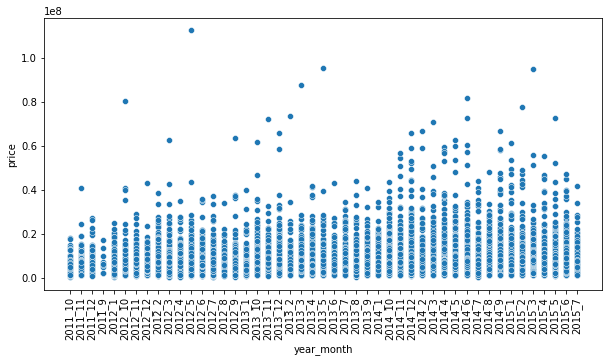

In [10]:
fig = plt.figure(figsize=[10,5])
ax = plt.gca()
p = sns.scatterplot(data=data.sort_values(by='year_month'), x='year_month', y='price', ax=ax)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

### Q3

In [81]:
year_month_max_price_df = data.groupby('year_month').agg({'price': max}).reset_index(drop=False)
year_month_max_price_df['dummy'] = 'dummy'
year_month_max_price_df.head()

,year_month,price,dummy
0,2011_10,999000.0,dummy
1,2011_11,998000.0,dummy
2,2011_12,994000.0,dummy
3,2011_9,9982700.0,dummy
4,2012_1,9981000.0,dummy


In [71]:
year_month_max_price_df['price'] = year_month_max_price_df['price'].astype(str)

In [73]:
data['price'] = data['price'].astype(str)

In [85]:
q = year_month_max_price_df.merge(data, on=['year_month', 'price'], how='right', suffixes=('_x', '_y'))
q.head()

,year_month,price,dummy,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area
0,2014_12,9711800.0,NaN,30392,2014-12-30,60,36.0,6.0,9.0,1.0,1974.0,3.0,5.0,3.0,9
1,2013_6,6643200.0,NaN,36540,2013-06-28,44,29.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,19
2,2013_9,5698300.0,NaN,94669,2013-09-15,62,60.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,80
3,2013_12,5055000.0,NaN,17531,2013-12-13,33,18.0,4.0,9.0,1.0,1970.0,1.0,6.0,2.0,15
4,2014_2,5425000.0,NaN,32159,2014-02-13,37,14.0,1.0,17.0,1.0,1991.0,1.0,1.0,2.0,74


In [98]:
q.loc[q.dummy.notnull()].sort_values(by='year_month')['price'].astype(float).astype(int).values

array([ 999000,  998000,  994000, 9982700, 9981000,  990900, 9770200,
        986000,  997900,  999900,  999900,  995000, 9978800, 9963000,
        992000,  994000,  994000, 9982700, 9929800, 9995000, 9989800,
       9990000, 9990000,  996000,  999000,  999900, 9972000, 9998500,
       9961900,  998000,  997900,  998000, 9998800, 9974400, 9999000,
       9990100, 9993600, 9978900, 9991800,  997000,  998000, 9969800,
        995900, 9990000, 9978800, 9969700, 9965300,  999000,  991000,
       9996500])

In [104]:
indices_most_expensive_prive_by_month = q.loc[q.dummy.notnull()].sort_values(by='year_month')['price'].index.values
indices_most_expensive_prive_by_month

array([28642, 25038, 27831, 14972, 26229, 22593, 22639, 14130, 17489,
       26687, 26686, 11151, 12938,  7855,  3664, 15963, 15964, 26141,
        3305, 24994, 11770, 24724, 24723,  5460, 11118, 17712, 15051,
       19918, 11721, 25831, 21582, 16622, 27048, 26790, 14571, 25437,
       23883, 22543, 25419, 14886,  8426, 25328, 27801,  7242, 24250,
       14108, 18158,  6559,  5766, 24353], dtype=int64)

In [101]:
# id_most_expensive_prive_by_month = data.groupby('year_month').max()['id'].values
# id_most_expensive_prive_by_month

In [102]:
# indices_most_expensive_prive_by_month = data[data['id'].isin(id_most_expensive_prive_by_month)].index.values
# indices_most_expensive_prive_by_month

### Q4

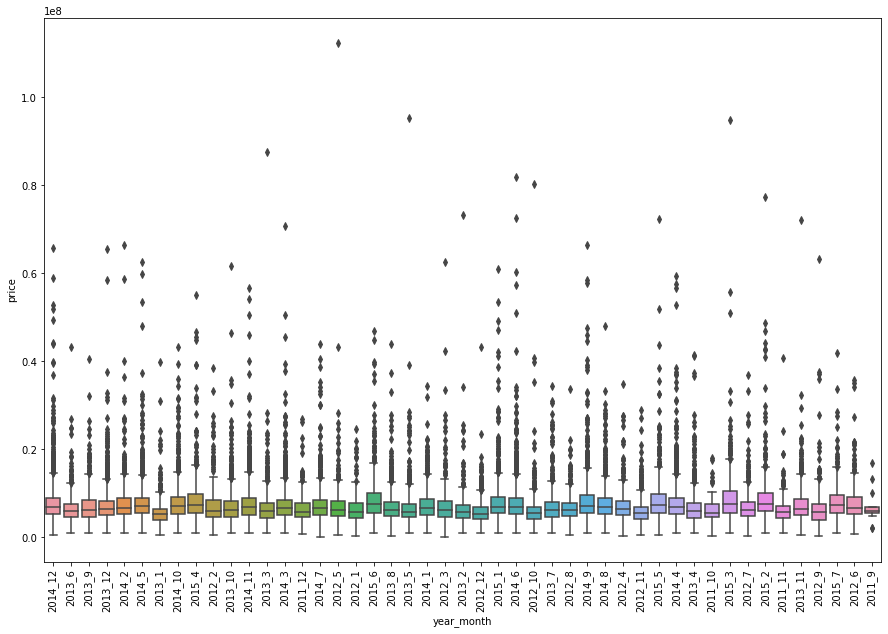

In [15]:
fig = plt.figure(figsize=[15,10])
ax = plt.gca()
sns.boxplot(data=data, x='year_month', y='price', ax=ax)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

### Q5

In [16]:
top_5_largest_apts = data.loc[data['full_sq'].argsort()[-5:][::-1], 'id'].values
top_5_largest_apts

array([95156, 95936, 32115, 49518, 41202], dtype=int64)

In [17]:
data[data['id'].isin(top_5_largest_apts)]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area,price,year_month
6172,32115,2014-10-20,639,637.0,18.0,19.0,4.0,2016.0,2.0,10.0,1.0,134,5150400.0,2014_10
9283,49518,2013-02-12,636,38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,55,11148600.0,2013_2
13473,41202,2014-05-15,635,NaN,3.0,17.0,1.0,NaN,2.0,0.0,NaN,72,6138600.0,2014_5
18260,95936,2012-07-16,731,44.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,133,13753500.0,2012_7
19303,95156,2012-09-19,5329,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,10,6841300.0,2012_9


### Q6

In [24]:
num_missing_life_sq = data.life_sq.isna().sum()
num_missing_life_sq

6065

### Q7

In [27]:
data['life_sq'].fillna(data['life_sq'].median(), inplace=True)

In [28]:
data.life_sq.isna().sum()

0

### Q8

In [34]:
corr1 = np.corrcoef(data.price, data.full_sq)[0,1]
corr1

0.33711308742057877

In [35]:
corr2 = np.corrcoef(data.price, data.life_sq )[0,1]
corr2

0.386558583114445

## Combining all in one file

In [105]:
with open('part1.csv', 'wb+') as f:
    np.savetxt(f, top_10_expensive_apts.reshape(1,-1), fmt="%d", delimiter=',')
    np.savetxt(f, indices_most_expensive_prive_by_month.reshape(1,-1), fmt="%d", delimiter=',')
    np.savetxt(f, top_5_largest_apts.reshape(1,-1), fmt="%d", delimiter=',')
    np.savetxt(f, num_missing_life_sq.reshape(1,-1), fmt="%d", delimiter=',')
    np.savetxt(f, np.array([corr1, corr2]).reshape(1,-1), delimiter=',', newline='')
    #np.savetxt(f, corr2.reshape(1,-1), delimiter=',', newline='')

In [44]:
top_10_expensive_apts.reshape(1,-1).shape

(1, 10)

# Part 2

In [467]:
HW_train_additional_data = pd.read_csv('data/HW_train_additional_data.csv')
HW_test_additional_data = pd.read_csv('data/HW_test_additional_data.csv')

In [468]:
# HW_train_additional_data.info()
# HW_train_additional_data.head()

In [469]:
HW_test_additional_data.info()
HW_test_additional_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1000 non-null   int64  
 1   population                       1000 non-null   int64  
 2   indust_part                      1000 non-null   float64
 3   preschool_facilities             1000 non-null   int64  
 4   school_facilities                1000 non-null   int64  
 5   hospital_beds_raion              544 non-null    float64
 6   healthcare_facilities            1000 non-null   int64  
 7   university_num                   1000 non-null   int64  
 8   sport_objects_facilities         1000 non-null   int64  
 9   additional_education_facilities  1000 non-null   int64  
 10  culture_objects_facilities       1000 non-null   int64  
 11  shopping_centers_facilities      1000 non-null   int64  
 12  office_num           

,id,population,indust_part,preschool_facilities,school_facilities,hospital_beds_raion,healthcare_facilities,university_num,sport_objects_facilities,additional_education_facilities,culture_objects_facilities,shopping_centers_facilities,office_num,green_part,prom_part,cafe_count,church_facilities,mosque,leisure_facilities
0,30307,247469,0.090799,13,14,NaN,5,0,16,16,0,15,2,12.16,0.00,5,0,0,0
1,87380,2546,0.034656,0,0,NaN,0,0,0,0,0,0,0,15.45,2.78,0,0,0,0
2,12874,4001,0.007122,0,0,NaN,0,0,0,0,0,1,0,15.29,2.83,1,0,0,0
3,57688,129207,0.007720,6,6,NaN,0,0,4,2,0,4,2,13.80,0.00,4,0,0,0
4,43433,122873,0.175055,4,4,NaN,1,0,6,0,0,0,3,0.01,0.00,4,1,0,0


In [470]:
HW_train_main_data = pd.read_csv('data/HW_train_main_data.csv')
HW_test_main_data = pd.read_csv('data/HW_test_main_data.csv')

In [471]:
# HW_train_main_data.info()
# HW_train_main_data.head()

In [472]:
HW_test_main_data.info()
HW_test_main_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1000 non-null   int64  
 1   timestamp            1000 non-null   object 
 2   full_sq              1000 non-null   int64  
 3   life_sq              797 non-null    float64
 4   floor                995 non-null    float64
 5   max_floor            688 non-null    float64
 6   material             688 non-null    float64
 7   build_year           559 non-null    float64
 8   num_room             688 non-null    float64
 9   kitch_sq             688 non-null    float64
 10  apartment condition  565 non-null    float64
 11  sub_area             1000 non-null   int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 93.9+ KB


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area
0,30307,2014-04-20,74,43.0,13.0,14.0,1.0,1996.0,3.0,10.0,2.0,60
1,87380,2015-01-17,29,NaN,6.0,17.0,1.0,NaN,1.0,1.0,1.0,87
2,12874,2014-07-08,80,NaN,8.0,17.0,1.0,NaN,3.0,1.0,NaN,103
3,57688,2013-01-15,53,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,80
4,43433,2012-06-15,36,19.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,117


In [473]:
train_combined = HW_train_main_data.merge(HW_train_additional_data, on='id')
train_combined.shape

(29000, 31)

In [474]:
test_combined = HW_test_main_data.merge(HW_test_additional_data, on='id')
test_combined.shape

(1000, 30)

## EDA

In [475]:
train_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29000 entries, 0 to 28999
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               29000 non-null  int64  
 1   timestamp                        29000 non-null  object 
 2   full_sq                          29000 non-null  int64  
 3   life_sq                          22935 non-null  float64
 4   floor                            28843 non-null  float64
 5   max_floor                        19887 non-null  float64
 6   material                         19887 non-null  float64
 7   build_year                       16059 non-null  float64
 8   num_room                         19887 non-null  float64
 9   kitch_sq                         19887 non-null  float64
 10  apartment condition              16088 non-null  float64
 11  sub_area                         29000 non-null  int64  
 12  price             

## Data Preparation

In [90]:
HW_train_additional_data = pd.read_csv('data/HW_train_additional_data.csv')
HW_test_additional_data = pd.read_csv('data/HW_test_additional_data.csv')

HW_train_main_data = pd.read_csv('data/HW_train_main_data.csv')
HW_test_main_data = pd.read_csv('data/HW_test_main_data.csv')

train_combined = HW_train_main_data.merge(HW_train_additional_data, on='id')
test_combined = HW_test_main_data.merge(HW_test_additional_data, on='id')

In [91]:
train_combined = train_combined[train_combined['floor'] < 29]
life_sq_imputer = train_combined['life_sq'].median()
print(life_sq_imputer)
train_combined['life_sq'].fillna(train_combined['life_sq'].median(), inplace=True)

30.0


C:\Users\victor\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


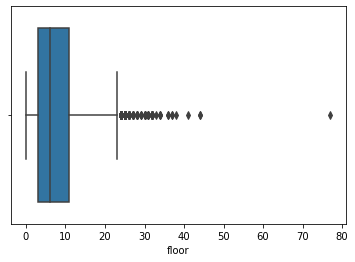

In [14]:
sns.boxplot(train_combined['floor'])

In [92]:
def save_data(train_combined):
    x_train = train_combined.drop(columns=['price'])
    y_train = train_combined['price']

    joblib.dump(x_train, 'x_train.j')
    joblib.dump(y_train, 'y_train.j')

def plug_date_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    return df

def drop_features(df):
    return df.drop(columns=['id', 'timestamp'])

def drop_many_missings_rows(df, threshold=7):
    many_missingness_rows_inds = df.isna().sum(axis=1) > threshold
    print(f"Dropping {many_missingness_rows_inds.sum()}/{len(df)} records")
    return df.drop(index=np.where(many_missingness_rows_inds)[0])

def drop_many_missings_columns(df, threshold=8000):
    many_missingness_cols_inds = np.where(df.isna().sum(axis=0) > threshold)[0]
    columns_to_drop = df.columns[many_missingness_cols_inds]
    print(f"Dropping {len(columns_to_drop)}/{len(df.columns)} columns:")
    for col in columns_to_drop:
        print(f"\t{col}")
    return df.drop(columns=columns_to_drop), columns_to_drop

def fillna_median(df):
    cols_with_missing_vals = df.columns[np.where(df.isna().any())[0]]
    filling_mapping = {}
    for col in cols_with_missing_vals:
        #value_to_fill = df[col].median()
        value_to_fill = df[col].median()
        filling_mapping[col] = value_to_fill
        print(f"Column {col}: Filling NA with {value_to_fill}")
        df.fillna(value_to_fill, inplace=True)
    return df, filling_mapping

def get_outliers(df, q):
    q_left = df.quantile(q)
    q_right = df.quantile(1-q)
    return q_left, q_right

def cap_outliers(df, q_left, q_right):
    for col in df.columns:
        less_inds = df[col] < q_left[col]
        greater_inds = df[col] > q_right[col]
        outliers_inds = less_inds | greater_inds
        print(f"Column {col} has {outliers_inds.sum()} outliers")
        df.loc[less_inds, col] = q_left[col]
        df.loc[greater_inds, col] = q_right[col]
    return df

def drop_outliers(df, q_left, q_right):
    return df[~((df < q_left |(df > q_right)).any(axis=1))]

def feature_engineering(df):
    for col in df.columns:
        if col != 'price':
            df[f"{col}_p2"] = np.power(df[col], 2)
            df[f"{col}_p05"] = np.sqrt(df[col])
            df[f"{col}_log"] = np.log(df[col]+1)
    return df

In [93]:
#train_combined = plug_date_features(train_combined)
train_combined = drop_features(train_combined)

In [230]:
train_combined = plug_date_features(train_combined)
train_combined = drop_features(train_combined)
train_combined = train_combined[train_combined['num_room'] < 10]
train_combined.drop(columns=['mosque', 'prom_part', 'month', 'healthcare_facilities', 'sub_area',
       'university_num', 'green_part', 'preschool_facilities', 'floor',
       'shopping_centers_facilities', 'material', 'life_sq', 'year',
       'max_floor', 'additional_education_facilities'], inplace=True)

train_combined = drop_many_missings_rows(train_combined)
train_combined, dropped_columns = drop_many_missings_columns(train_combined)
#q_left, q_right = get_outliers(train_combined, 0.05)
#train_combined = cap_outliers(train_combined, q_left, q_right)
#train_combined = drop_outliers(train_combined, q_left, q_right)
#train_combined = train_combined[train_combined['full_sq'] <= 1000]
#train_combined = train_combined[train_combined['culture_objects_facilities'] < 10]
train_combined, filling_mapping = fillna_median(train_combined)
#train_combined = feature_engineering(train_combined)
train_combined.reset_index(drop=True, inplace=True)

Dropping 0/19883 records
Dropping 1/16 columns:
	hospital_beds_raion
Column build_year: Filling NA with 1979.0
Column apartment condition: Filling NA with 2.0


In [94]:
print(f'train_combined shape: {train_combined.shape}')
save_data(train_combined)

train_combined shape: (28802, 29)


In [419]:
# detecting_ourliers 


Column full_sq has 508 outliers
Column life_sq has 333 outliers
Column floor has 211 outliers
Column sub_area has 367 outliers
Column price has 579 outliers
Column population has 0 outliers
Column indust_part has 283 outliers
Column preschool_facilities has 0 outliers
Column school_facilities has 0 outliers
Column healthcare_facilities has 287 outliers
Column university_num has 47 outliers
Column sport_objects_facilities has 0 outliers
Column additional_education_facilities has 0 outliers
Column culture_objects_facilities has 0 outliers
Column shopping_centers_facilities has 0 outliers
Column office_num has 0 outliers
Column green_part has 293 outliers
Column prom_part has 290 outliers
Column cafe_count has 34 outliers
Column church_facilities has 1 outliers
Column mosque has 147 outliers
Column leisure_facilities has 257 outliers
Column year has 0 outliers
Column month has 0 outliers


In [316]:
q_left

full_sq                                 27.0
life_sq                                  1.0
floor                                    1.0
max_floor                                0.0
material                                 1.0
num_room                                 1.0
kitch_sq                                 0.0
sub_area                                 1.0
price                              1016830.0
population                            2546.0
indust_part                              0.0
preschool_facilities                     0.0
school_facilities                        0.0
healthcare_facilities                    0.0
university_num                           0.0
sport_objects_facilities                 0.0
additional_education_facilities          0.0
culture_objects_facilities               0.0
shopping_centers_facilities              0.0
office_num                               0.0
green_part                               0.0
prom_part                                0.0
cafe_count

In [317]:
train_combined[(train_combined < q_left).any(axis=1)]

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,sub_area,price,population,...,shopping_centers_facilities,office_num,green_part,prom_part,cafe_count,church_facilities,mosque,leisure_facilities,year,month
66,15,15.0,6.0,30.0,30.0,30.0,30.0,145,1113000.0,123000,...,2,2,14.54,0.00,7,2,0,0,2012,3
69,4,1.0,1.0,1.0,1.0,1.0,1.0,103,6487600.0,4001,...,1,0,15.29,2.83,1,0,0,0,2014,9
74,67,49.0,9.0,30.0,30.0,30.0,30.0,37,1005000.0,174831,...,7,1,42.51,0.00,2,0,0,0,2013,3
100,20,13.0,4.0,30.0,30.0,30.0,30.0,40,4014300.0,104434,...,1,4,5.80,0.00,6,0,0,0,2013,1
142,65,38.0,8.0,12.0,1.0,3.0,8.0,82,1009000.0,175518,...,9,6,1.57,0.00,3,1,0,0,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27444,18,13.0,2.0,5.0,2.0,1.0,2.0,12,3933700.0,104410,...,2,4,0.00,64.26,0,0,0,1,2013,9
27494,1,1.0,1.0,1.0,1.0,1.0,1.0,94,5488600.0,21819,...,2,3,11.66,0.97,0,1,0,0,2015,1
27513,102,0.0,17.0,0.0,4.0,3.0,0.0,102,12995300.0,9553,...,0,1,17.94,1.51,0,0,0,0,2014,7
27534,83,73.0,14.0,30.0,30.0,30.0,30.0,74,725700.0,111023,...,1,0,0.00,0.00,3,0,0,0,2012,6


In [318]:
train_combined.iloc[74]

full_sq                            6.700000e+01
life_sq                            4.900000e+01
floor                              9.000000e+00
max_floor                          3.000000e+01
material                           3.000000e+01
num_room                           3.000000e+01
kitch_sq                           3.000000e+01
sub_area                           3.700000e+01
price                              1.005000e+06
population                         1.748310e+05
indust_part                        3.717782e-02
preschool_facilities               7.000000e+00
school_facilities                  7.000000e+00
healthcare_facilities              1.000000e+00
university_num                     0.000000e+00
sport_objects_facilities           7.000000e+00
additional_education_facilities    7.000000e+00
culture_objects_facilities         0.000000e+00
shopping_centers_facilities        7.000000e+00
office_num                         1.000000e+00
green_part                         4.251

In [322]:
train_combined.columns[np.where((train_combined < q_left).values[74])[0]]

Index(['price'], dtype='object')

In [295]:
train_combined.index == 72

array([False, False, False, ..., False, False, False])

In [284]:
q_left

full_sq                                 27.0
life_sq                                  1.0
floor                                    1.0
max_floor                                0.0
material                                 1.0
num_room                                 1.0
kitch_sq                                 0.0
sub_area                                 1.0
price                              1016830.0
population                            2546.0
indust_part                              0.0
preschool_facilities                     0.0
school_facilities                        0.0
healthcare_facilities                    0.0
university_num                           0.0
sport_objects_facilities                 0.0
additional_education_facilities          0.0
culture_objects_facilities               0.0
shopping_centers_facilities              0.0
office_num                               0.0
green_part                               0.0
prom_part                                0.0
cafe_count

In [261]:
print(f"New Shape: {train_combined.shape}")
train_combined.head()

New Shape: (27566, 28)


,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,sub_area,price,population,...,shopping_centers_facilities,office_num,green_part,prom_part,cafe_count,church_facilities,mosque,leisure_facilities,year,month
0,60,36.0,6.0,9.0,1.0,3.0,5.0,9,9711800.0,155572,...,16,1,2.86,0.00,0,0,0,0,2014,12
1,44,29.0,9.0,NaN,NaN,NaN,NaN,19,6643200.0,111874,...,11,5,9.26,2.71,1,0,0,0,2013,6
2,62,60.0,4.0,NaN,NaN,NaN,NaN,80,5698300.0,129207,...,4,2,13.80,0.00,4,0,0,0,2013,9
3,33,18.0,4.0,9.0,1.0,1.0,6.0,15,5055000.0,125354,...,2,0,7.46,0.00,1,0,0,0,2013,12
4,37,14.0,1.0,17.0,1.0,1.0,1.0,74,5425000.0,111023,...,1,0,0.00,0.00,3,0,0,0,2014,2


In [6]:

# x_test = test_combined.drop(columns=['price'])
# y_test = test_combined['price']

In [458]:
#dtrain = xgb.DMatrix(x_train, label=y_train)

In [459]:
#dtrain.save_binary('train.dmatrix')
joblib.dump(x_train, 'x_train.j')
joblib.dump(y_train, 'y_train.j')

['y_train.j']

In [ ]:
#dtest = xgb.DMatrix(x_train, label=y_train)

## Modeling

In [135]:
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

In [147]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model = xgb.XGBRegressor(n_jobs=4, n_estimators=3)

In [150]:
random_search = RandomizedSearchCV(model, 
                                   param_distributions=params, 
                                   n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   n_jobs=4, 
                                   cv=cv, 
                                   verbose=3, 
                                   random_state=1)

In [151]:
%%time
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 1.57 s


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.4s finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.3, train_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_...
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None

In [154]:
random_search.best_score_

-18893154607392.45

In [ ]:
random_search.

In [130]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
num_round = 10
model = xgb.train(dtrain=dtrain, params=param, num_boost_round=3)

In [ ]:
model.predict()

In [158]:
18893154607392.45 / 8537589508838.697

2.2129378073088386

In [255]:
scores = [18893154607392.45, 8537589508838.697, 8136121348918, -7492278697769.455, -8897113477785.029]

for score1 in scores:
    for score2 in scores:
        if score1 > score2:
            print(f"{score2} is {round(score1 / score2, 2)} times better than {score1}")

8537589508838.697 is 2.21 times better than 18893154607392.45
8136121348918 is 2.32 times better than 18893154607392.45
-7492278697769.455 is -2.52 times better than 18893154607392.45
8136121348918 is 1.05 times better than 8537589508838.697
-7492278697769.455 is -1.14 times better than 8537589508838.697
-7492278697769.455 is -1.09 times better than 8136121348918


In [ ]:
!245000000
-8897113477785.029
-7492278697769.455
-9838043071466
-11111410047429.
-7186763760837
-7408912127406

In [328]:
np.sqrt(9838043071466)

78.11091488475017

## Predictions

## lasso

In [582]:
model = joblib.load('model_lasso.j')

In [583]:
ids = test_combined['id']

In [584]:
test_combined = plug_date_features(test_combined)

In [585]:
test_combined.drop(columns=dropped_columns.tolist() + ['timestamp', 'id'], inplace=True)
#test_combined.drop(columns=['timestamp'], inplace=True)

In [586]:
test_combined = cap_outliers(test_combined, q_left, q_right)

Column full_sq has 11 outliers
Column life_sq has 6 outliers
Column floor has 13 outliers
Column max_floor has 9 outliers
Column material has 0 outliers
Column num_room has 1 outliers
Column kitch_sq has 6 outliers
Column sub_area has 12 outliers
Column population has 0 outliers
Column indust_part has 10 outliers
Column preschool_facilities has 0 outliers
Column school_facilities has 0 outliers
Column healthcare_facilities has 0 outliers
Column university_num has 2 outliers
Column sport_objects_facilities has 0 outliers
Column additional_education_facilities has 0 outliers
Column culture_objects_facilities has 0 outliers
Column shopping_centers_facilities has 0 outliers
Column office_num has 0 outliers
Column green_part has 14 outliers
Column prom_part has 14 outliers
Column cafe_count has 1 outliers
Column church_facilities has 0 outliers
Column mosque has 2 outliers
Column leisure_facilities has 12 outliers
Column year has 0 outliers
Column month has 0 outliers


In [587]:
for col in filling_mapping:
    test_combined[col].fillna(filling_mapping[col], inplace=True)

In [588]:
test_combined = feature_engineering(test_combined)

In [589]:
sclaer = joblib.load('scaler.j')
test_combined = sclaer.transform(test_combined)

In [592]:
y_hat = model.predict(test_combined)

In [594]:
output_df = pd.DataFrame({'id': ids, 'predicted_price': y_hat})

In [595]:
output_df.to_csv('prediction.csv', index=False)

## xgboost

In [82]:
test_combined = HW_test_main_data.merge(HW_test_additional_data, on='id')

In [83]:
test_combined['life_sq'].fillna(life_sq_imputer, inplace=True)

In [84]:
test_combined['life_sq'].isna().sum()

0

In [85]:
model = joblib.load('model.j')
ids = test_combined['id']
#test_combined = plug_date_features(test_combined)
test_combined.drop(columns=#dropped_columns.tolist() + 
                   ['timestamp', 'id'], inplace=True)
# test_combined.drop(columns=['mosque', 'university_num', 'prom_part', 'month', 'life_sq', 'sub_area',
#        'floor', 'green_part', 'material', 'school_facilities',
#        'additional_education_facilities', 'max_floor'], inplace=True)
# test_combined.drop(columns=['mosque', 'prom_part', 'month', 'healthcare_facilities', 'sub_area',
#        'university_num', 'green_part', 'preschool_facilities', 'floor',
#        'shopping_centers_facilities', 'material', 'life_sq', 'year',
#        'max_floor', 'additional_education_facilities'], inplace=True)
#test_combined = cap_outliers(test_combined, q_left, q_right)
# for col in filling_mapping:
#     test_combined[col].fillna(filling_mapping[col], inplace=True)
#test_combined = feature_engineering(test_combined)

In [86]:
test_combined.columns

Index(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
       'num_room', 'kitch_sq', 'apartment condition', 'sub_area', 'population',
       'indust_part', 'preschool_facilities', 'school_facilities',
       'hospital_beds_raion', 'healthcare_facilities', 'university_num',
       'sport_objects_facilities', 'additional_education_facilities',
       'culture_objects_facilities', 'shopping_centers_facilities',
       'office_num', 'green_part', 'prom_part', 'cafe_count',
       'church_facilities', 'mosque', 'leisure_facilities'],
      dtype='object')

In [87]:
#q = test_combined.drop(columns=['id', 'timestamp'])
y_hat_xgboost = model.predict(test_combined.values)

In [88]:
#y_res = y_hat_xgboost * 0.6 + y_hat * 0.4

In [89]:
output_df = pd.DataFrame({'id': ids, 'predicted_price': y_hat_xgboost})
output_df.to_csv('prediction.csv', index=False)

In [219]:
importance_threshold = 0.02
sorted_inds_importance = np.argsort(model.feature_importances_)

inds_exceed_threshold = model.feature_importances_[sorted_inds_importance] > importance_threshold

<BarContainer object of 15 artists>

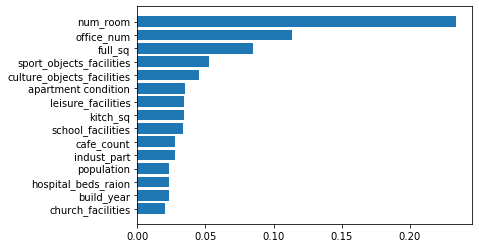

In [220]:
plt.barh(test_combined.columns[sorted_inds_importance][inds_exceed_threshold], 
         model.feature_importances_[sorted_inds_importance][inds_exceed_threshold])

In [221]:
columns_to_keep = test_combined.columns[sorted_inds_importance][inds_exceed_threshold]
columns_to_drop = test_combined.columns[sorted_inds_importance][~inds_exceed_threshold]

In [222]:
columns_to_keep

Index(['church_facilities', 'build_year', 'hospital_beds_raion', 'population',
       'indust_part', 'cafe_count', 'school_facilities', 'kitch_sq',
       'leisure_facilities', 'apartment condition',
       'culture_objects_facilities', 'sport_objects_facilities', 'full_sq',
       'office_num', 'num_room'],
      dtype='object')

In [223]:
columns_to_drop

Index(['mosque', 'prom_part', 'month', 'healthcare_facilities', 'sub_area',
       'university_num', 'green_part', 'preschool_facilities', 'floor',
       'shopping_centers_facilities', 'material', 'life_sq', 'year',
       'max_floor', 'additional_education_facilities'],
      dtype='object')

In [12]:
model.feature_importances_

array([0.01659551, 0.0046111 , 0.00558089, 0.00730882, 0.00521774,
       0.00497488, 0.00526322, 0.00502476, 0.02999508, 0.01032007,
       0.00401281, 0.00555801, 0.00680107, 0.00680116, 0.02582941,
       0.00423257, 0.00993297, 0.00563041, 0.00683522, 0.0044548 ,
       0.00409892, 0.01034034, 0.01186757, 0.        , 0.0209787 ,
       0.00528717, 0.00366769, 0.06774584, 0.06105562, 0.00614649,
       0.01360405, 0.00452643, 0.00569413, 0.00353693, 0.00334248,
       0.00863597, 0.00423703, 0.0051991 , 0.00879649, 0.00558786,
       0.00527193, 0.00318863, 0.01093963, 0.00553003, 0.00381824,
       0.00338457, 0.00295455, 0.00308815, 0.00719241, 0.00578008,
       0.00470806, 0.0070089 , 0.00529892, 0.0039715 , 0.00701345,
       0.01215964, 0.007922  , 0.01191187, 0.00380198, 0.00924499,
       0.00929301, 0.00559967, 0.00703761, 0.00356815, 0.00969627,
       0.01178415, 0.00754605, 0.00332294, 0.0032984 , 0.06907489,
       0.00651802, 0.00460922, 0.00493717, 0.00454482, 0.00392

In [18]:
train_combined

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,sub_area,price,population,...,shopping_centers_facilities,office_num,green_part,prom_part,cafe_count,church_facilities,mosque,leisure_facilities,year,month
0,60,36.0,6.0,9.0,1.0,3.0,5.0,9,9711800.0,155572,...,16,1,2.86,0.00,0,0,0,0,2014,12
1,44,29.0,9.0,30.0,30.0,30.0,30.0,19,6643200.0,111874,...,11,5,9.26,2.71,1,0,0,0,2013,6
2,62,60.0,4.0,30.0,30.0,30.0,30.0,80,5698300.0,129207,...,4,2,13.80,0.00,4,0,0,0,2013,9
3,33,18.0,4.0,9.0,1.0,1.0,6.0,15,5055000.0,125354,...,2,0,7.46,0.00,1,0,0,0,2013,12
4,37,14.0,1.0,17.0,1.0,1.0,1.0,74,5425000.0,111023,...,1,0,0.00,0.00,3,0,0,0,2014,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27561,28,17.0,1.0,30.0,30.0,30.0,30.0,110,4513500.0,101982,...,0,1,4.88,5.55,1,0,0,0,2013,8
27562,38,30.0,9.0,17.0,1.0,1.0,1.0,134,4779900.0,75377,...,23,141,12.24,0.00,71,15,0,0,2014,4
27563,55,30.0,9.0,16.0,1.0,2.0,8.0,38,7260000.0,178264,...,4,4,12.32,0.00,0,0,0,0,2013,9
27564,37,19.0,3.0,16.0,5.0,1.0,9.0,43,6018000.0,153248,...,11,6,39.80,7.01,3,0,0,0,2013,11


In [19]:
test_combined

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,additional_education_facilities,culture_objects_facilities,shopping_centers_facilities,office_num,green_part,prom_part,cafe_count,church_facilities,mosque,leisure_facilities
0,30307,2014-04-20,74,43.0,13.0,14.0,1.0,1996.0,3.0,10.0,...,16,0,15,2,12.16,0.00,5,0,0,0
1,87380,2015-01-17,29,NaN,6.0,17.0,1.0,NaN,1.0,1.0,...,0,0,0,0,15.45,2.78,0,0,0,0
2,12874,2014-07-08,80,NaN,8.0,17.0,1.0,NaN,3.0,1.0,...,0,0,1,0,15.29,2.83,1,0,0,0
3,57688,2013-01-15,53,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,2,0,4,2,13.80,0.00,4,0,0,0
4,43433,2012-06-15,36,19.0,16.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,3,0.01,0.00,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28684,2015-04-05,54,NaN,2.0,17.0,1.0,NaN,2.0,1.0,...,0,0,0,0,0.00,0.00,0,0,0,0
996,65212,2014-05-22,78,45.0,5.0,10.0,1.0,1995.0,3.0,10.0,...,16,0,15,2,13.84,0.00,6,0,0,0
997,11218,2014-12-18,2,1.0,26.0,1.0,1.0,1.0,1.0,1.0,...,0,0,7,2,2.07,20.49,3,0,0,0
998,57238,2013-06-09,55,33.0,6.0,NaN,NaN,NaN,NaN,NaN,...,3,0,16,1,17.62,0.00,4,0,0,0
